In [21]:
import cv2
import glob
import imp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import numpy as np
import os
import pickle
from scipy.signal import find_peaks_cwt
import image_utils
import lane_finding
%matplotlib inline

## Camera Calibration

In order to perform a perspective transform on the image the distortions introduced by the camera lense must be corrected. The two distortions addressed here are radial and tangential distortion. Radial distortion is the effect where the magnification changes radially as you move away from the image axis. The change in magnification as a function of radial distance can be modeled with a quadratic. Tangential distortion is the effect that happens when the imaging plane is tilted in the x and y directions. This causes half the image to look farther away and half of the image to appear closer.

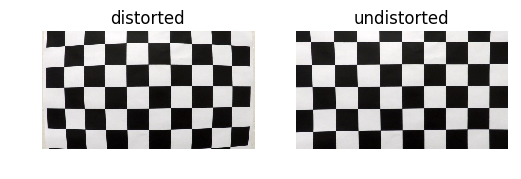

In [23]:
cal_file = 'cal_params.p'

# load calibration images
calibration_images = [mpimg.imread(f) for f in glob.glob("camera_cal/calibration*.jpg")]

if not os.path.exists(cal_file):

    # compute camera matrix and distortion parameters
    mtx, dist = image_utils.calibrate_camera(calibration_images)
    
    with open(cal_file, 'wb') as f:
        pickle.dump((mtx, dist), f)
else:
    with open(cal_file, 'rb') as f:
        mtx, dist = pickle.load(f)

fig, axes = plt.subplots(1,2)

# original image
axes[0].imshow(calibration_images[0])
axes[0].set_title('distorted')
axes[0].axis('off')

# undistorted image
axes[1].imshow(image_utils.undistort(calibration_images[0], mtx, dist))
axes[1].set_title('undistorted')
axes[1].axis('off')

plt.show()

To test the calibration parameters, a calibration image was undistorted. Radial distortion can clearly be seen in the image on the left while the undistorted image does not show any radial distortion. So far so good.

## Perspective Transform

The next part of the pipeline involves applying a perspective transform to produce a birds eye view of the road. To do this we need to identify four points that describe a trapezoid in the image and map these to a rectangle. The trapezoid will be selected using an image of a car driving straight.

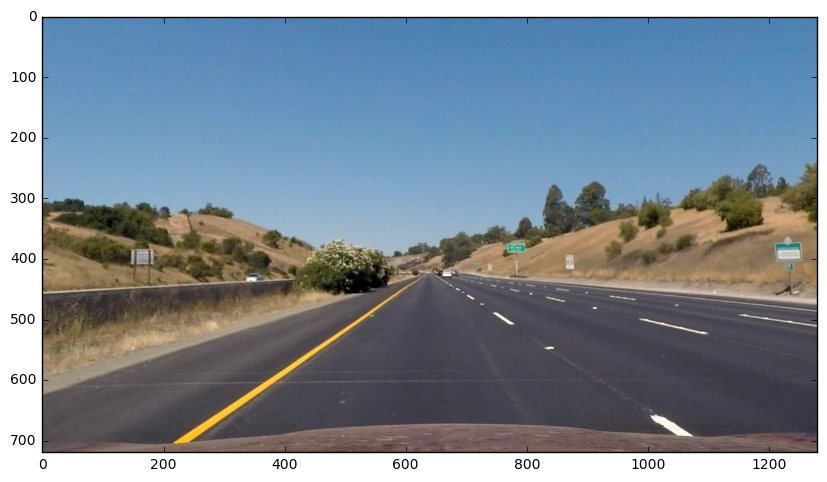

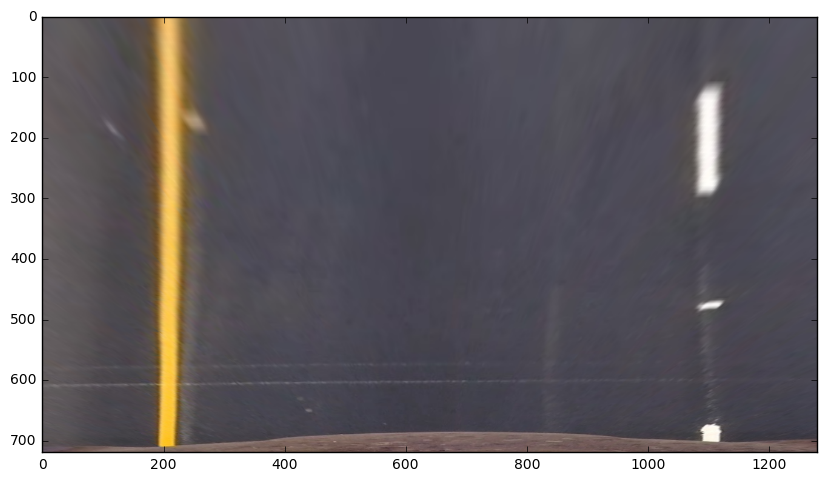

In [28]:
# read images with straight lane lines
straight_imgs = [mpimg.imread(f) for f in glob.glob("test_images/straight*.jpg")]

# start with the first straight line image
straight_img = image_utils.undistort(straight_imgs[0], mtx, dist)

img_shape = straight_img.shape

# image dimensions
height = img_shape[0]
width = img_shape[1]

# window parameters
x_center = width/2
y_top = height/1.5

# source trapezoid coordinates
src = np.float32([(x_center + 0.2*x_center, y_top),
                  (x_center - 0.2*x_center, y_top),
                  (x_center + 0.9*x_center, height),
                  (x_center - 0.9*x_center, height)])

# destination rectangle coordinates
dst = np.float32([(0, 0),
                  (width, 0),
                  (0, height),
                  (width, height)])

# plot original image
fig = plt.figure(figsize=(10,10))
plt.imshow(straight_img)

# apply perspective transform
warped, M, Minv = image_utils.perspective_transform(straight_img, src, dst)
fig = plt.figure(figsize=(10,10))
plt.imshow(warped)

After a significant amount of experimentation it looks like the source and destination points that I have selected above yield a decent perspective transform.

## Color Thresholding

Now that the perspective transform is sorted out it is time to determine optimal color thresholding parameters. To start lets capture some frames from the challenge videos to see what we are dealing with. From sifting through the worst images appear to be the ones that involve transitions from bright to dark. In the harder challenge the camera saturates and makes it impossible to see the left lane.

In [ ]:
project_images = [mpimg.imread(f) for f in glob.glob("test_images/*.jpg")]

fig, axes = plt.subplots(len(project_images), 4, figsize=(20,20))
for idx, img in enumerate(project_images):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    axes[idx, 0].imshow(img)
    axes[idx, 0].axis('off')
    axes[idx, 1].imshow(hls[:,:,0], cmap='gray')
    axes[idx, 1].axis('off')
    axes[idx, 2].imshow(hls[:,:,1], cmap='gray')
    axes[idx, 2].axis('off')
    axes[idx, 3].imshow(hls[:,:,2], cmap='gray')
    axes[idx, 3].axis('off')
plt.subplots_adjust(hspace=0.01, wspace=0.01)

In [ ]:
challenge_images = [mpimg.imread(f) for f in glob.glob("test_images/*.png")]

fig, axes = plt.subplots(len(challenge_images), 4, figsize=(20,20))
for idx, img in enumerate(challenge_images):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    axes[idx, 0].imshow(img)
    axes[idx, 0].axis('off')
    axes[idx, 1].imshow(hls[:,:,0], cmap='gray')
    axes[idx, 1].axis('off')
    axes[idx, 2].imshow(hls[:,:,1], cmap='gray')
    axes[idx, 2].axis('off')
    axes[idx, 3].imshow(hls[:,:,2], cmap='gray')
    axes[idx, 3].axis('off')
plt.subplots_adjust(hspace=0.01, wspace=0.01)

In [ ]:
test = project_images[0]
hsv = cv2.cvtColor(test, cv2.COLOR_RGB2HSV)
sat = hsv[:,:,1] # saturation channel
sat_binary = np.zeros_like(sat)
sat_binary[(sat > 160) & (sat < 255)] = 1
plt.imshow(sat_binary, cmap="gray")

After a lot of experimentation with different color spaces it looks like the saturation channel in HSV color space is a good candidate for thresholding.

## Gradient Thresholds

In addition to color thresholding gradient masks can be used to help identify the lane lines. In this section the parameters for the gradient operators will be found that best identify the lane lines.

In [ ]:
test = project_images[0]
blur = utilities.guassian_blur(test, kernel_size=5)

# Apply each of the thresholding functions
gradx = utilities.abs_sobel_thresh(blur, orient='x', thresh_min=10, thresh_max=255)
grady = utilities.abs_sobel_thresh(blur, orient='y', thresh_min=60, thresh_max=255)
mag_binary = utilities.mag_thresh(blur, mag_thresh=(40, 255))
dir_binary = utilities.dir_threshold(blur, thresh=(.65, 1.05))

# Combine four masks
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(6,1, figsize=(20,10))

# blurred image
ax0.imshow(blur)
ax0.set_title("Blurred Image")
ax0.axis('off')

# x gradient threshold
ax1.imshow(gradx, cmap='gray')
ax1.set_title("Sobel X")
ax1.axis('off')

# y gradient threshold
ax2.imshow(grady, cmap='gray')
ax2.set_title("Sobel Y")
ax2.axis('off')

# gradient magnitude threshold
ax3.imshow(mag_binary, cmap='gray')
ax3.set_title("Gradient Magnitude Threshold")
ax3.axis('off')

# gradient direction threshold
ax4.imshow(dir_binary, cmap='gray')
ax4.set_title("Gradient Direction Threshold")
ax4.axis('off')

# combined mask
ax5.imshow(combined, cmap='gray')
ax5.set_title("Combined Mask")
ax5.axis('off')

## Combined Color and Gradient Thesholding

Now that the parameters have been identified for both the gradient thresholding and color thresholding lets see how the two combined perform.

In [ ]:
import imp
imp.reload(utilities)

for img in project_images:
    fig = plt.figure()
    plt.imshow(utilities.pipeline(img, mtx, dist)[0], cmap='gray')

## Finding the lanes

To find the lanes the warped top-view image will be broken into n-horizontal slices. Within each slice a histogram will be computed along the x-axis that averages the number of non-zero entries in the image for all y values with at each x value. Looking at the image above this should yield two peaks. To further improve this a moving average is applied to smooth the curves.

In [ ]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def lane_histogram(top_down, windows=5):
    height, width = top_down.shape[0], top_down.shape[1]
    
    # window parameters
    window_size = int(height/(windows+1))
    
    fig, axes = plt.subplots(windows, 2, figsize=(20,20))
    for i in range(windows):
        hslice = top_down[i*window_size:i*window_size+window_size, :]
        hslice[hslice != 0] = 1
        
        # plot horizontal slice
        axes[i, 0].imshow(hslice, cmap='gray')
        axes[i, 0].axis('off')
        
        # find lane windows
        mean_lane = np.mean(hslice, axis=0)
        mean_lane = moving_average(mean_lane, np.int(width/20))
        axes[i,1].plot(mean_lane)
        axes[i,1].plot(mean_lane>0.05)
        axes[i,1].set_ylim(0,1)
        
        # find left and right peak
        idx = find_peaks_cwt(mean_lane, [100], max_distances=[800])
        if len(idx) == 2:
            # left peak
            axes[i, 1].axvline(x=np.min(idx), color='r')
            # right peak
            axes[i, 1].axvline(x=np.max(idx), color='k')
        
lane_histogram(utilities.pipeline(test, mtx, dist)[0])

In [ ]:
def find_lanes(img, windows=5, peak_offset=50):
    # copy input image
    top_down = np.copy(img).astype(np.uint8)
    
    # create masks
    l_mask = np.zeros_like(img, dtype=np.uint8)
    r_mask = np.zeros_like(img, dtype=np.uint8)
    
    # image dimensions
    height, width = top_down.shape[0], top_down.shape[1]
    
    # window parameters
    window_size = int(height/(windows))
    
    # compute initial peaks using majority of image
    mean_lane = np.mean(top_down[height/2:, :], axis=0)
    mean_lane = moving_average(mean_lane, width/20)
    idx = find_peaks_cwt(mean_lane, [100], max_distances=[800])
    
    # right and left peak indicies
    r_peak = np.max(idx[:2])
    r_peak_last = r_peak
    l_peak = np.min(idx[:2])
    l_peak_last = l_peak
    
    # peak location delta
    dr = 0
    dl = 0
    
    for i in range(windows):
        
        y_min = i*window_size
        y_max = y_min + window_size
        
        # generate horizontal slice
        hslice = top_down[y_min:y_max, :]
        
        # find peaks
        mean_lane = np.mean(hslice, axis=0)
        mean_lane = moving_average(mean_lane, width/20)
        idx = find_peaks_cwt(mean_lane, [100], max_distances=[800])
        
        # two peaks found
        if len(idx) >= 2: 
            r_peak = np.max(idx[:2])
            l_peak = np.min(idx[:2])
        
        # one peak found
        elif len(idx) == 1: 
            if np.abs(r_peak - idx[0]) < np.abs(l_peak - idx[0]):
                r_peak = idx[0]
                l_peak = l_peak_last + dl
            else:
                l_peak = idx[0]
                r_peak = r_peak_last + dr
        
        # no peaks found
        else:
            r_peak = r_peak_last + dr
            l_peak = l_peak_last + dl
            
        # outlier detection
        if np.abs(r_peak - r_peak_last) > 100:
            r_peak = r_peak_last
        if np.abs(l_peak - l_peak_last) > 100:
            l_peak = l_peak_last
        
        # populate lane mask for slice
        r_min, r_max = np.clip([r_peak-peak_offset, r_peak+peak_offset], 0, width)
        l_min, l_max = np.clip([l_peak-peak_offset, l_peak+peak_offset], 0, width)
        r_mask[y_min:y_max, r_min:r_max] = 1
        l_mask[y_min:y_max, l_min:l_max] = 1
        
        if i > 0:
            dr = r_peak - r_peak_last
            dl = l_peak - l_peak_last
            
        r_peak_last = r_peak
        l_peak_last = l_peak
            
    return np.bitwise_and(top, r_mask), np.bitwise_and(top, l_mask)

top = utilities.pipeline(project_images[4], mtx, dist)[0]
r_lane, l_lane = find_lanes(top, windows=8)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
ax1.imshow(top)
ax1.set_title("Top View")
ax2.imshow(r_lane)
ax2.set_title("Right Lane")
ax3.imshow(l_lane)
ax3.set_title("Left Lane")

## Finding Curvature

Now that the lanes have been isolated we can fit second order polynomials to the left and right lanes to identify the curvature.

In [ ]:
# fit right lane
r_lane_pts = np.argwhere(r_lane == 1)
r_fit = np.polyfit(r_lane_pts[:,0], r_lane_pts[:,1], deg=2)
r_y = np.arange(11)*height/10
r_x = r_fit[0]*r_y**2 + r_fit[1]*r_y + r_fit[2]

# fit left lane
l_lane_pts = np.argwhere(l_lane == 1)
l_fit = np.polyfit(l_lane_pts[:,0], l_lane_pts[:,1], deg=2)
l_y = np.arange(11)*height/10
l_x = l_fit[0]*l_y**2 + l_fit[1]*l_y + l_fit[2]

# plot fit overlayed on left and right lane
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(l_lane, cmap='gray')
ax1.plot( l_x, l_y, 'r')
ax1.axis('off')

ax2.imshow(r_lane, cmap='gray')
ax2.plot( r_x, r_y, 'r')
ax2.axis('off')

In [ ]:
top = utilities.pipeline(project_images[4], mtx, dist)[0]
r_lane, l_lane = find_lanes(top, windows=8)
r_fit, l_fit = utilities.fit_lanes(r_lane, l_lane)
plt.figure()
plt.imshow(l_lane + r_lane, cmap='gray')
plt.plot(r_fit[:,0], r_fit[:,1], 'r')
plt.plot(l_fit[:,0], l_fit[:,1], 'r')

In [ ]:
def draw_pw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)

def draw_lanes(undistorted, top, r_fit, l_fit, Minv):
    warp = np.zeros_like(top).astype(np.uint8)
    color_warp = np.dstack((warp, warp, warp))
    
    pts = np.vstack((l_fit, r_fit[::-1,:]))

    cv2.fillPoly(color_warp, np.uint([pts]), (0,255,255))
    
    left_lane_color = (255,255,0)        # yellow
    right_lane_color = (255,255,255)     # white

    # draw lane lines using fit
    draw_pw_lines(color_warp,np.int_([l_fit]),left_lane_color)
    draw_pw_lines(color_warp,np.int_([r_fit]),right_lane_color)

    # revert image back to original perspective
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 

    result = cv2.addWeighted(undistorted, 1, newwarp, 0.5, 0)
    
    return result

# full pipe line
undistorted = utilities.undistort(project_images[0], mtx, dist)
top, M, Minv = utilities.pipeline(undistorted, mtx, dist)
right_lane, left_lane = utilities.find_lanes(top, windows=8)
r_fit, l_fit = utilities.fit_lanes(right_lane, left_lane)
result = draw_lanes(undistorted, top, r_fit, l_fit, Minv)
plt.imshow(result)

# Complete Pipeline

All of the steps have been completed individually now.

* Calibration and Distortion Removal
* Perspective Transform
* Color Thresholding
* Gradient Thresholding
* Lane Identification
* Polynomial Fitting

The next step is to create a method that performs the entire pipeline and apply it to each from the of the project video.

In [2]:
import ipywidgets
import imp
imp.reload(image_utils)
imp.reload(lane_finding)

img = mpimg.imread("test_images/test4.jpg")
blur = image_utils.guassian_blur(img, kernel_size=5)

def color(hmin, hmax, smin, smax):
    filtered = lane_finding.process_color(blur, hue_thresh=(hmin, hmax), sat_thresh=(smin, smax))
    plt.figure(figsize=(10,10))
    plt.imshow(filtered, cmap='gray')

def gradx(tmin, tmax): 
    filtered = image_utils.abs_sobel_thresh(blur, orient='x', thresh=(tmin, tmax))
    plt.figure(figsize=(10,10))
    plt.imshow(filtered, cmap='gray')
    
def grady(tmin, tmax): 
    filtered = image_utils.abs_sobel_thresh(blur, orient='y', thresh=(tmin, tmax))
    plt.figure(figsize=(10,10))
    plt.imshow(filtered, cmap='gray')
    

def gradm(tmin, tmax): 
    filtered = image_utils.mag_thresh(blur, sobel_kernel=3, thresh=(tmin, tmax))
    plt.figure(figsize=(10,10))
    plt.imshow(filtered, cmap='gray')
    
def gradd(tmin, tmax): 
    filtered = image_utils.dir_threshold(blur, sobel_kernel=3, thresh=(tmin, tmax))
    plt.figure(figsize=(10,10))
    plt.imshow(filtered, cmap='gray')

slider = lambda tmin, tmax, value: ipywidgets.IntSlider(value=value, min=tmin, max=tmax)
fslider = lambda tmin, tmax, value: ipywidgets.FloatSlider(value=value, min=tmin, max=tmax)

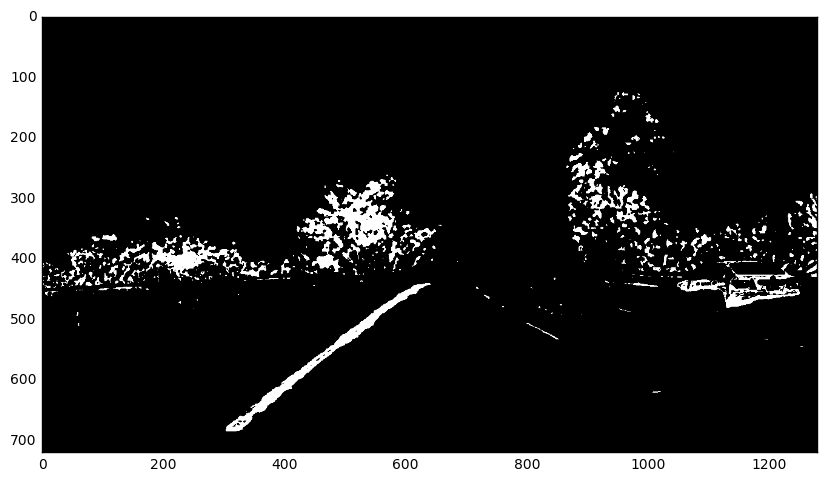

In [3]:
ipywidgets.interact(color, hmin=slider(0,255,0), hmax=slider(0,255,255), smin=slider(0,255,95), smax=slider(0,255,255))

<function __main__.gradx>

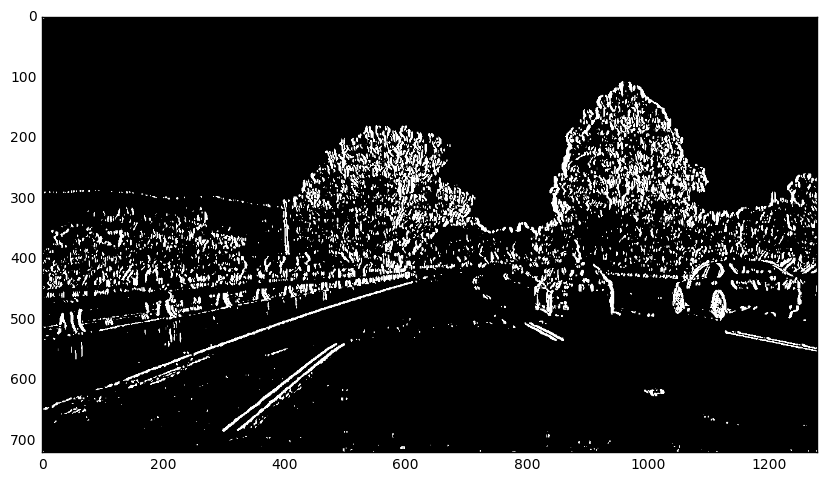

In [4]:
ipywidgets.interact(gradx, tmin=slider(0,255,20), tmax=slider(0,255,255))

<function __main__.grady>

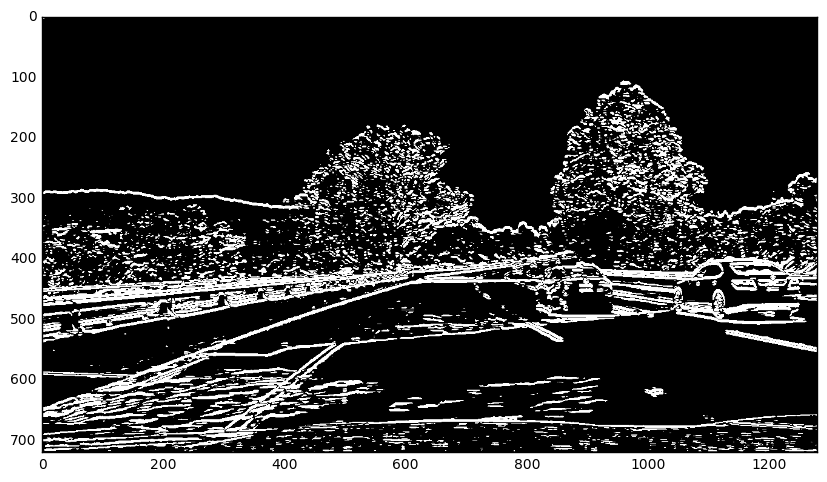

In [6]:
ipywidgets.interact(grady, tmin=slider(0,255,20), tmax=slider(0,255,255))

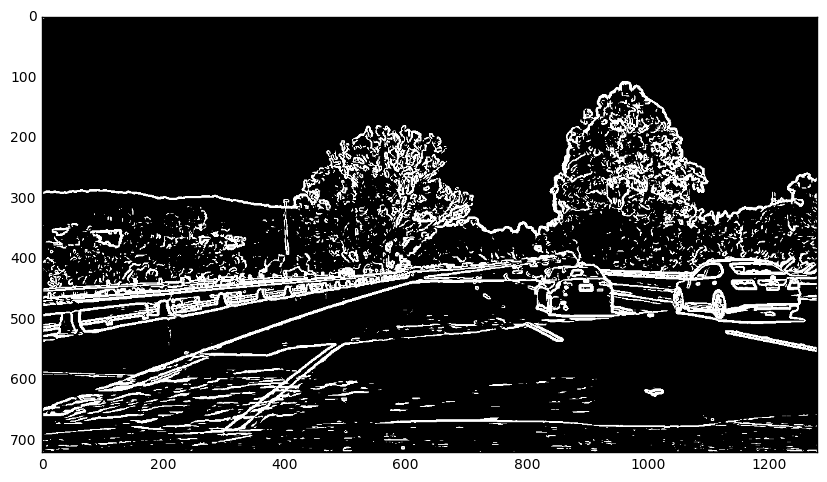

In [7]:
ipywidgets.interact(gradm, tmin=slider(0,255,30), tmax=slider(0,255,255))

<function __main__.gradd>

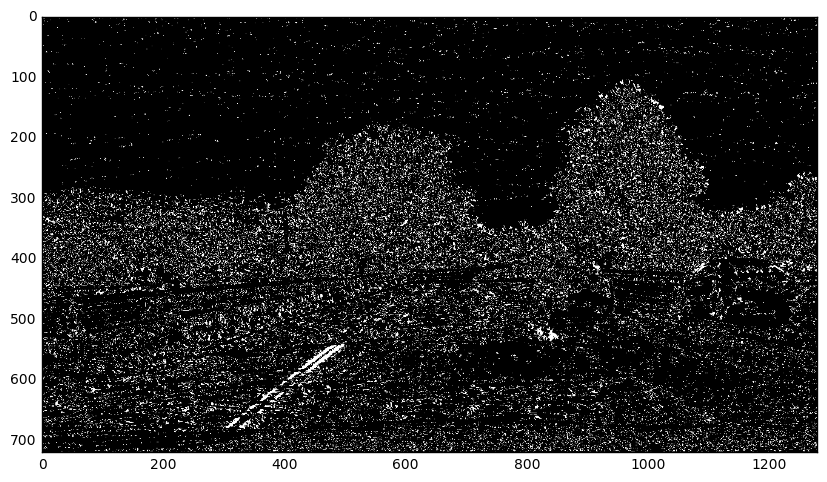

In [8]:
ipywidgets.interact(gradd, tmin=fslider(0,np.pi/2,0.8), tmax=fslider(0,np.pi/2,1.10))

In [44]:
with open("cal_params.p", "rb") as calfile:
    mtx, dist = pickle.load(calfile)
    
with open("thresholds.p", "rb") as threshfile:
    threshold_params = pickle.load(threshfile)
    
img = mpimg.imread("test_images/test1.jpg")
top = lane_finding.pipeline(img, **threshold_params)[0]

(720, 0)

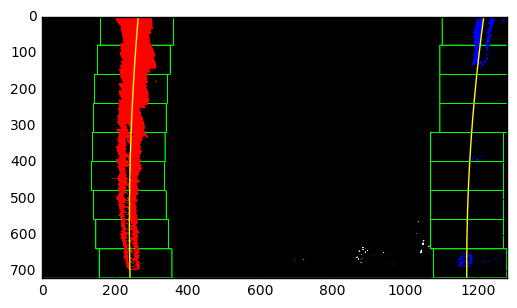

In [45]:
binary_warped = top
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

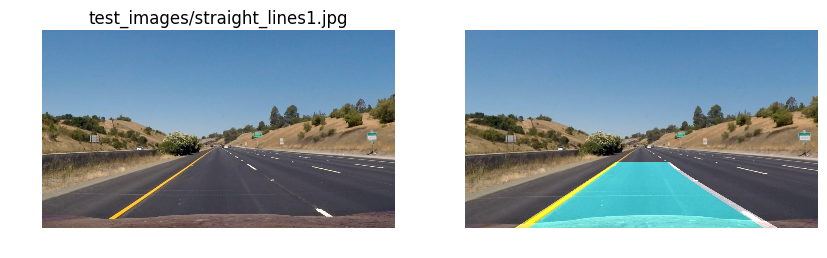

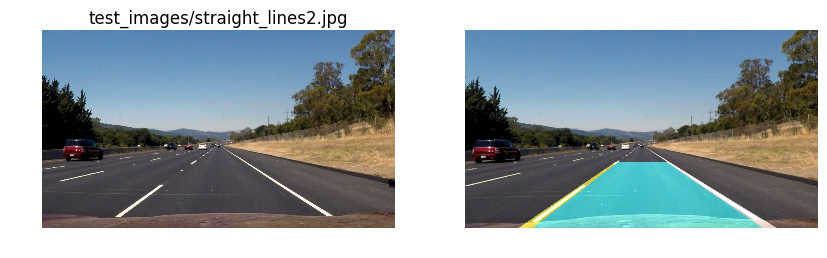

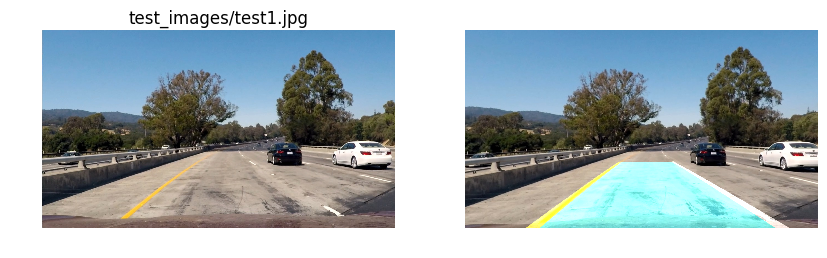

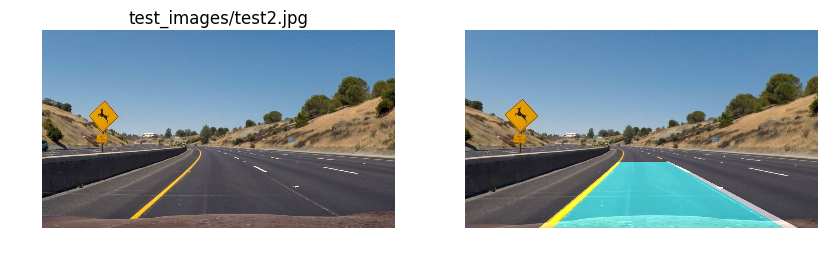

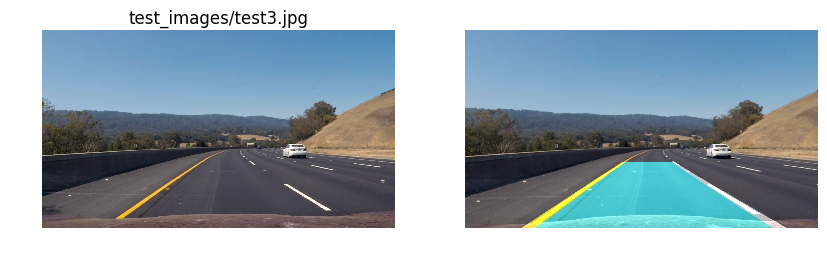

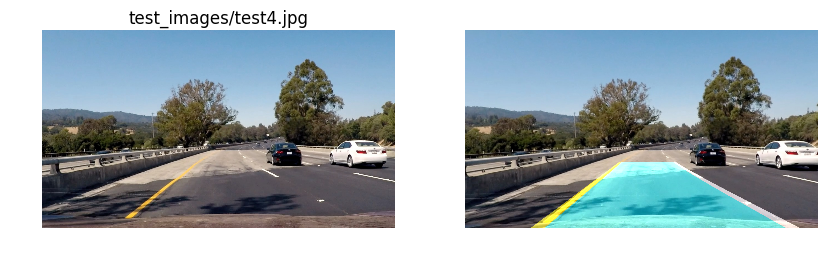

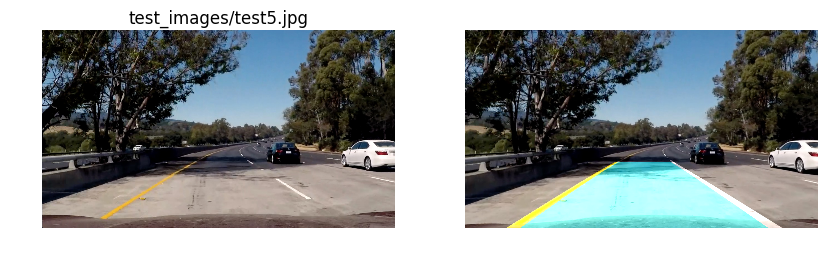

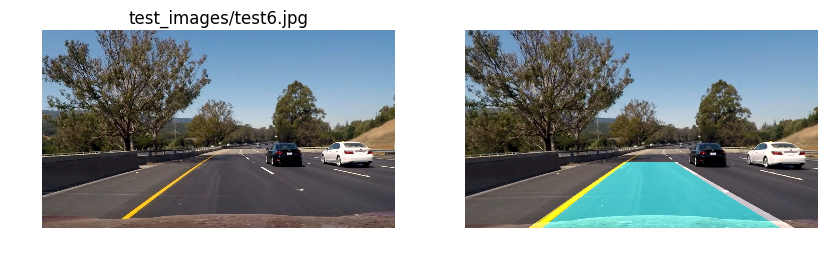

In [17]:
with open("cal_params.p", "rb") as calfile:
    mtx, dist = pickle.load(calfile)

if not os.path.exists("thresholds.p"):
    with open("thresholds.p", "wb") as thresholdfile:
        threshold_params = dict()
        threshold_params['sat_thresh'] = (95, 255)
        threshold_params['hue_thresh'] = (0, 100)
        threshold_params['x_thresh'] = (20, 255)
        threshold_params['y_thresh'] = (55, 255)
        threshold_params['mag_thresh'] = (55, 255)
        threshold_params['dir_thresh'] = (0.8, 1.10)
        pickle.dump(threshold_params, thresholdfile)
else:
    with open("thresholds.p", "rb") as thresholdfile:
        threshold_params = pickle.load(thresholdfile)

images = glob.glob("test_images/*.jpg")
for img_file in images:
    img = mpimg.imread(img_file)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.imshow(img)
    ax1.set_title(img_file)
    ax1.axis('off')
    ax2.imshow(lane_finding.process_image(img, mtx, dist, **threshold_params))
    ax2.axis('off')

In [18]:
with open("cal_params.p", "rb") as f:
    mtx, dist = pickle.load(f)
    
with open("thresholds.p", "rb") as f:
    threshold_params = pickle.load(f)
    
# create lambda function that takes image as input and calls process_image
image_handler = lambda x: lane_finding.process_image(x, mtx, dist, **threshold_params)

# apply image handler to every frame of project video
project_output = 'project_output.mp4'
clip = VideoFileClip("project_video.mp4")
project_clip = clip.fl_image(image_handler) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False, fps=10)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 504/505 [04:26<00:00,  2.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 5min 49s, sys: 30.9 s, total: 6min 20s
Wall time: 4min 28s


In [20]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))